In [1]:
# Import some basic libraries
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
sns.set_context('paper')

# Hands-on Activity 10.4: Uncertainty Propagation Through a Boundary Value Problem

## Objectives
+ To propagate uncertainty through a boundary value problem

## Exaple: Propagating Uncertainty Through a Differential Equation
Consider the steady state heat equation on a heterogeneous rod with no heat sources:
$$
\frac{d}{dx}\left(c(x)\frac{d}{dx}T(x)\right) = 0,
$$
for $x$ between $0$ and $1~\;\mbox{m}$ and boundary values:
$$
T(0) = 400^\circ\mbox{C}\;\mbox{and}\;T(1~\mbox{m}) = 4^\circ\mbox{C}.
$$
We are interested in cases in which we are uncertain about the conductivity, $c(x)$.
Let's work a little bit on modeling this uncertainty in the first place.

### Modeling our state of knowledge about the conductivity of the rod

We need to come up with $c(x)$. The first thing we need to do is write down everything we know about the rod:

+ The rod is one meter long. That is, we are ignoring the possibility of an uncertain length.
+ The rod is from laminations of $2$ different materials: fiberglass (labeled material 0) and steel (labeled material 1).
+ We know that the concentration of the fiberglas is $0.3$ and the concentration of steel is $0.7$.
+ We know that the thermal conductivity of the fiberglass $0.045\;\mbox{Wm}^{-1}\mbox{K}^{-1}$ and of the second $38\;\mbox{Wm}^{-1}\mbox{K}^{-1}$.
+ The rod is made out of $D$ segments and each one of these segments consists of only one of the two types of material. Even though we do not know the exact number of segments $D$, we do expect them to be around $100$.

Let's turn this information into a mathematical model for the conductivity of the rod.
First, the number of segments $D$ must be a discrete random variable with a given expectation, $\mathbb{E}[D] = 100$.
The best choice here is a Poisson random variable with the correct rate parameter.
It is:
$$
D \sim \operatorname{Poisson}(100).
$$
Let's just plot its pmf to build some intuition about it:

Text(0, 0.5, '$p(D=d)$')

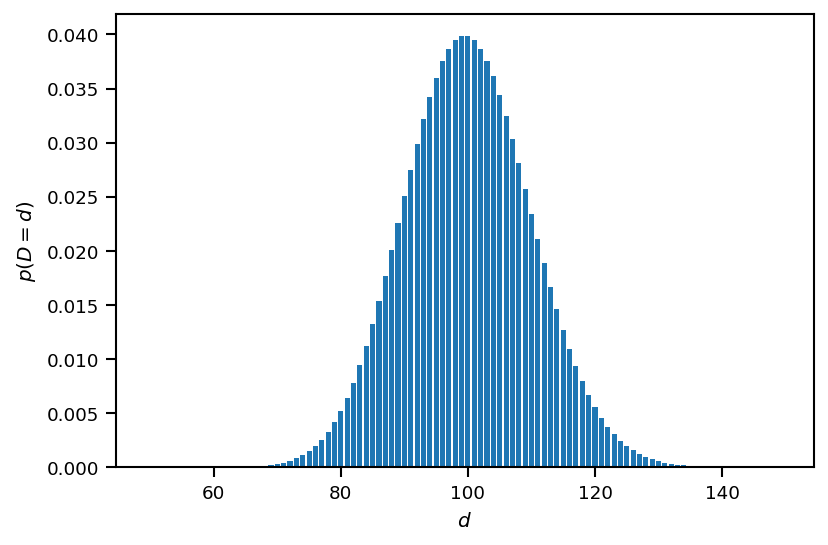

In [2]:
import scipy.stats as st
D = st.poisson(100)
fig, ax = plt.subplots(dpi=150)
ax.bar(np.arange(50, 150), D.pmf(np.arange(50, 150)))
ax.set_xlabel('$d$')
ax.set_ylabel('$p(D=d)$')

Okay, this looks reasonable. Let's move to the segment coordinates.
The coordinates of these segments are also random.
Specifically, the leftmost coordinate is just $X_0 = 0$, the right-most is $X_D = 1$.
We know this because we know the total length.
What are the intermediate $D-1$ coordinates?
Well, since we are not told anything else, let's assume that these intermediate coordinates are generated by uniformly sampling in $[0,1]$ and then sorting the numbers.
Mathematically, the random vector $X_{1:D-1}$ is given by:
$$
(X_1,\dots, X_{D-1}) = \operatorname{sort}(U_1,\dots,U_{D-1}),
$$
where
$$
U_i \sim U([0,1]).
$$
Let's visualize this as well to develop our intuition.

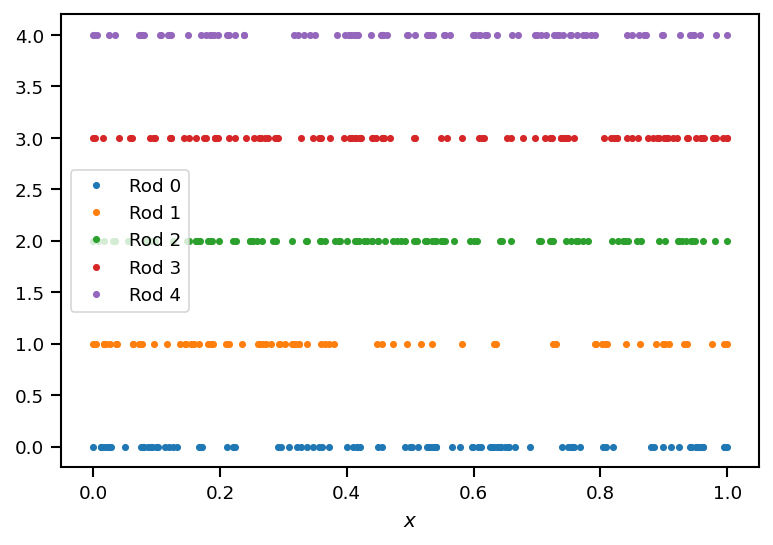

In [3]:
# Create some random rod segments
fig, ax = plt.subplots(dpi=150)
for i in range(5):
    # Get the number of segments
    d = D.rvs()
    # Get the intermediate coordinates
    u = np.random.rand(d-1)
    # Create the coordinates of the segment in a sorted manner (including the end points)
    x = np.hstack([[0.0], u, [1.0]])
    # Plot the segment locations
    ax.plot(x, np.ones(d+1) * i, '.', label='Rod {0:d}'.format(i))
ax.set_xlabel('$x$')
plt.legend(loc='best')

Okay, this looks reasonable as well.
Let's move on to the material types.
Each segment will be assigned a random material.
Say that the material we assign to segment $d$ is $M_d$ taking values in $\{0, 1\}$.
What distribution should we assign to the $M_d$'s?
Well, we expect the concentration of material $0$ to be $0.3$ and of material $1$ to be $0.7$.
We can interpret this information as the statement that:
$$
\mathbb{E}\left[\frac{1}{D}\sum_{d=1}^D1_{\{0\}}(X_d)\right] = 0.3,
$$
and
$$
\mathbb{E}\left[\frac{1}{D}\sum_{d=1}^D1_{\{1\}}(X_d)\right] = 0.7.
$$
These equations just say that the expected percentage of material $0$ is $0.3$ and similarly for material $1$.
What distribution for $M_d$ is comptability with this information.
To proceed, let's assume that all the $M_d$'s are independent and identically distributed conditioned on $D$.
Then we can write:
$$
\mathbb{E}\left[\frac{1}{D}\sum_{d=1}^D1_{\{0\}}(M_d)\right] = \mathbb{E}\left[\mathbb{E}\left[\frac{1}{D}\sum_{d=1}^D1_{\{0\}}(M_d)|D\right]\right],
$$
where the internal expectation is conditional on $D$, i.e., it is with respect to $p(M_1,\dots,M_D|D)$.
So, in this internal expectation you can treat $D$ as constant and simplify the equation as:
$$
\mathbb{E}\left[\mathbb{E}\left[\frac{1}{D}\sum_{d=1}^D1_{\{0\}}(M_d)|D\right]\right] = 
\mathbb{E}\left[\frac{1}{D}\sum_{d=1}^D\mathbb{E}\left[1_{\{0\}}(M_d)|D\right]\right].
$$
Now because the $X_d$'s are identically distributed conditioned on $D$, the internal expectation is simply the conditional probability of $X_d$ taking the value $0$, i.e., we can rewrite it as:
$$
\mathbb{E}\left[\frac{1}{D}\sum_{d=1}^D\mathbb{E}\left[1_{\{0\}}(M_d)|D\right]\right]
= 
\mathbb{E}\left[\frac{1}{D}\sum_{d=1}^Dp(M_d = 0|D)\right].
$$
So, we see that if we take $p(M_d = 0|D) = 0.3$ independently of what $D$ is, then we are going to satisfy the initial equation.
Let's do exactly that. This means that we can take the $M_d$ to follow Categorical distributions:
$$
M_d \sim \operatorname{Categorical}(0.3, 0.7),
$$
for $d=1,\dots,D$.

Okay, now we have created random variables that model the number of segments and then the material we have on each segment. How do we put this all together to create the thermal conductivity random function.
Well, this is now simple. When we want the thermal conductivity at location $x$, all we have to do is to find the segment $d$ containing $x$, and look up the conductivity of material type $M_d$.
If the conductivity of the material $0$ is $c_0 = 0.3$ and that of material $1$ is $c_1 = 0.8$, then we can write this function as:
$$
c(x) = \sum_{d=1}^Dc_{M_d}1_{[X_{d-1},X_{d}]}(x).
$$
Notice that the conductivity is a function of $D$ and the $X_d$'s and the $M_d$'s.
So, it is a random function.

### Getting a bit organized using Python classes

The model we put together for the rod conductivity is failrly complicated.
Let me repeat it here for clarity.
It is as follows.
The number of segments is:
$$
D\sim \operatorname{Poisson}(100).
$$
The $D+1$ segment coordinates $X_0,\dots,X_D$ are:
$$
X_0 = 0,
$$
$$
X_D = 1,
$$
and the intermediate are:
$$
(X_1,\dots, X_{D-1}) = \operatorname{sort}(U_1,\dots,U_{D-1}),
$$
where the segment coordinates are uniformly sampled:
$$
U_i \sim U([0,1]),
$$
for $i=1,\dots,D-1$.
Finally, the material types are 
$$
M_d \sim \operatorname{Categorical}(0.3, 0.7),
$$
for $d=1,\dots,D$, and the random thermal conductivity function:
$$
c(x) = \sum_{d=1}^Dc_{M_d}1_{[X_{d-1},X_{d}]}(x).
$$
This is a lot to keep track of.
We would like to group everything together so that we minimize the possibility of bugs.
We are going to achieve this using Python classes. If you want to learn what classes are, you may want to pause at this point and watch this [tutorial video](https://youtu.be/wfcWRAxRVBA). Otherwise, skip the definition and go to the point where we just use them.

We are going to make two clases a ``Rod`` and a ``RandomRod``. Their descriptions are as follows:

+ ``Rod`` represents a specific rod, a rod sample if you like. We will be able to initialize it using the segment coordinates, and the material ids that go in each segment along with the thermal conductivity that comes with each material. This class will have the following methods:
    - ``Rod.get_conductivity(x)`` will be function that gives us the thermal conductivity of the speciment at location ``x``.
    - ``Rod.__repr__()`` will return a text representation of the speciment. This is the function that will be used when you try to ``print`` a rod.
    - ``Rod.plot()`` will be a function that visualizes the rod.
    
+ ``RandomRod`` represents a ... random rod. It essentially collects all the random variables that affect the characteristics of the rod, so it needs to know the rate of the Poisson distribution for $D$, the concentration of each material, and, of course, the thermal conductivity associated with each material. This class will have the following methods:
    - ``RandomRod.rvs()`` will be a function that samples a random ``Rod``.
    
Okay, let's do it. First the ``Rod``. You can skip the definition of the class and go directly to the code block where we use it.

In [4]:
class Rod(object):
    
    """
    A class representing a rod made out of different materials.
    
    Arguments:
    
    segment_coords   -   Coordinates of the segments (both left and right). Total N + 1
                         if segments are N.
    mat_id           -   The material ids on each segment. Total N. Values must start
                         at 0 and go sequential to the maximum number of materials
                         we have on the rod.
    mat_cond         -   The conductivity associaed with each unique material id.
    """
    
    def __init__(self, segment_coords, mat_id, mat_cond):
        # Save segments for later
        self.segment_coords = np.sort(segment_coords)
        # The total number of segments
        self.num_segments = self.segment_coords.shape[0] - 1
        # Save the material id on each segment for later
        self.mat_id = mat_id
        # The number of unique materials
        self.num_mat = len(np.unique(self.mat_id))
        # The conductivity on each segment
        self.segment_cond = np.array([mat_cond[m] for m in mat_id])
        
    def _get_conductivity(self, x):
        """
        Evaluate the conductivity at location x, assuming x is a scalar.
        """
        # Find the segment that contains x
        for i in range(self.num_segments):
            if self.segment_coords[i] <= x and x <= self.segment_coords[i + 1]:
                return self.segment_cond[i]
            
    def get_conductivity(self, x):
        """
        Evaluate the conductivity at location x. This works when x is a scalar or
        a numpy array.
        """
        if isinstance(x, float):
            return self._get_conductivity(x)
        # This checks if x is a numpy array. The function will fail other wise.
        assert isinstance(x, np.ndarray)
        # And it will only work with 1D arrays
        assert x.ndim == 1
        # This evaluates the conductivity at all the elements of x and returns
        # a numpy array
        return np.array([self._get_conductivity(xx) for xx in x])
    
    def __repr__(self):
        """
        Get a string representation of the rod.
        """
        s = 'SEGID\tLeft\tRight\tMat.\tCond.\n'
        s += '-' * 37 + '\n'
        for i in range(self.num_segments):
            s += ' {0:d}\t{1:1.2f}\t{2:1.2f}\t{3:d}\t{4:1.2f}\n'.format(i, segment_coords[i],
                                                                 segment_coords[i+1],
                                                                 material_on_each_segment[i],
                                                                 segment_cond[i])
        return s
    
    def plot(self, ax=None):
        """
        Plots the bar. Returns the axes object on which the rod is plot.
        
        Arguments:
        
        ax    -    An axes object to plot on. If not given, a new one will be created.
        """
        from matplotlib.patches import Rectangle
        if ax is None:
            fig, ax = plt.subplots()
        for i in range(self.num_segments):
            mat_segment = Rectangle((self.segment_coords[i], -0.1), 
                                    width=self.segment_coords[i+1] - self.segment_coords[i],
                                    height=0.1, color=sns.color_palette()[self.mat_id[i]])
            ax.add_patch(mat_segment)
        ax.set_ylim(-0.1, 1.1)
        return ax

Let's play with this class for a little bit by generating a random material:

In [5]:
# First let use help on Rod and see what we get:
help(Rod)

Help on class Rod in module __main__:

class Rod(builtins.object)
 |  Rod(segment_coords, mat_id, mat_cond)
 |  
 |  A class representing a rod made out of different materials.
 |  
 |  Arguments:
 |  
 |  segment_coords   -   Coordinates of the segments (both left and right). Total N + 1
 |                       if segments are N.
 |  mat_id           -   The material ids on each segment. Total N. Values must start
 |                       at 0 and go sequential to the maximum number of materials
 |                       we have on the rod.
 |  mat_cond         -   The conductivity associaed with each unique material id.
 |  
 |  Methods defined here:
 |  
 |  __init__(self, segment_coords, mat_id, mat_cond)
 |      Initialize self.  See help(type(self)) for accurate signature.
 |  
 |  __repr__(self)
 |      Get a string representation of the rod.
 |  
 |  get_conductivity(self, x)
 |      Evaluate the conductivity at location x. This works when x is a scalar or
 |      a numpy array

So this just shows the text that we put inside tripple quotes.
Let's make a rod.

In [6]:
# Let's take two materials with conductivities:
material_cond = [0.3, 0.8]
# The number of materials we have:
num_materials = len(material_cond)
# The number of segments we want to have
num_segments = 100
# The segment coordinates. First segment starts at zero. The last ends at one.
# The intermediate segments have random locations.
segment_coords = np.hstack([[0.0], np.sort(np.random.rand(num_segments - 1)), [1.0]])
# Now let's sample a different conductivity for each segment
material_on_each_segment = np.random.randint(num_materials, size=num_segments)
# Conductivity on each segment
segment_cond = np.array([material_cond[m] for m in material_on_each_segment])
# Now create the rod object:
rod = Rod(segment_coords, material_on_each_segment, material_cond)
# You can evaluate the rod object at point to get the conductivity:
rod.get_conductivity(0.8)

0.8

In [7]:
# Or you can print it to see how it looks like (this calls rod.__repr__())
print(rod)

SEGID	Left	Right	Mat.	Cond.
-------------------------------------
 0	0.00	0.00	0	0.30
 1	0.00	0.00	1	0.80
 2	0.00	0.00	0	0.30
 3	0.00	0.01	0	0.30
 4	0.01	0.02	0	0.30
 5	0.02	0.02	0	0.30
 6	0.02	0.03	0	0.30
 7	0.03	0.03	0	0.30
 8	0.03	0.06	0	0.30
 9	0.06	0.07	0	0.30
 10	0.07	0.07	0	0.30
 11	0.07	0.07	1	0.80
 12	0.07	0.07	0	0.30
 13	0.07	0.07	1	0.80
 14	0.07	0.08	0	0.30
 15	0.08	0.08	1	0.80
 16	0.08	0.09	0	0.30
 17	0.09	0.10	1	0.80
 18	0.10	0.11	0	0.30
 19	0.11	0.11	0	0.30
 20	0.11	0.12	1	0.80
 21	0.12	0.12	1	0.80
 22	0.12	0.13	1	0.80
 23	0.13	0.16	0	0.30
 24	0.16	0.16	0	0.30
 25	0.16	0.17	1	0.80
 26	0.17	0.20	1	0.80
 27	0.20	0.22	0	0.30
 28	0.22	0.24	1	0.80
 29	0.24	0.26	1	0.80
 30	0.26	0.28	1	0.80
 31	0.28	0.32	1	0.80
 32	0.32	0.33	0	0.30
 33	0.33	0.33	1	0.80
 34	0.33	0.34	1	0.80
 35	0.34	0.34	0	0.30
 36	0.34	0.34	1	0.80
 37	0.34	0.37	0	0.30
 38	0.37	0.37	0	0.30
 39	0.37	0.37	1	0.80
 40	0.37	0.39	0	0.30
 41	0.39	0.40	0	0.30
 42	0.40	0.46	0	0.30
 43	0.46	0.46	1	0.80
 44	0.46	0.47	0	0.30

<AxesSubplot:>

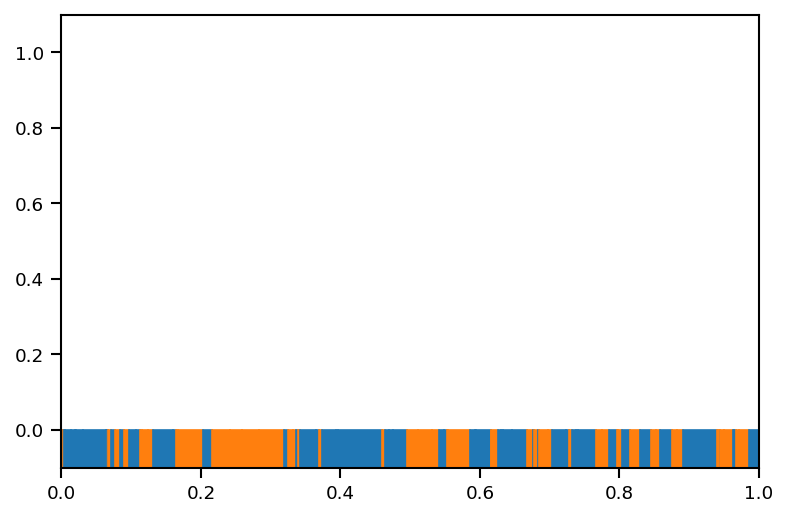

In [8]:
# Or you can plot it
fig, ax = plt.subplots(dpi=150)
rod.plot(ax=ax)

Now, let's make the ``RandomRod`` class:

In [9]:
class RandomRod(object):
    
    """
    A class modeling a random rod.
    
    Arguments:
    
    av_num_segments    -    The ``rate`` of the Poisson distribution giving
                            the number of segments.
    mat_probs          -    The probabilities of the categorical specifying
                            each material goes on each segment.
    mat_cond         -   The conductivity associaed with each unique material id.
    """
    
    def __init__(self, av_num_segments, mat_probs, mat_cond):
        # Save some info internally for later usage
        self.av_num_segments = av_num_segments
        self.mat_probs = mat_probs
        self.mat_cond = mat_cond
        # Make the Poisson variable corresponding to the number of segments
        self.D = st.poisson(av_num_segments)
        # Make the Uniform giving the location of the segment coordinates
        self.U = st.uniform()
        # Make the Categorical random variable that allows us to pick the material
        # id on each segment
        self.M = st.rv_discrete(name='M', values=(np.arange(len(mat_probs)), mat_probs))
        
    def _rvs(self):
        """
        Generate a single random rod.
        """
        # Draw the number of segments
        d = self.D.rvs()
        # Draw the coordinates
        segment_coords = np.hstack([[0.0], np.sort(self.U.rvs(size=d - 1)), [1.0]])
        # Draw the material type on each segment
        mat_ids = self.M.rvs(size=d)
        # Generate the rod
        return Rod(segment_coords, mat_ids, self.mat_cond)
    
    def rvs(self, size=1):
        """
        Generate many random rods.
        """
        if size == 1:
            return self._rvs()
        return [self._rvs() for _ in range(size)]

Let's initialize it:

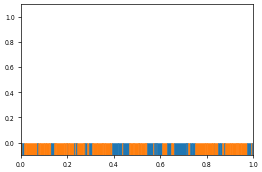

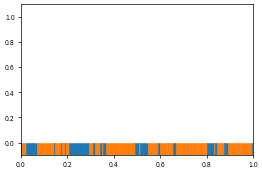

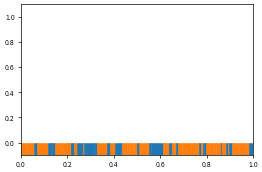

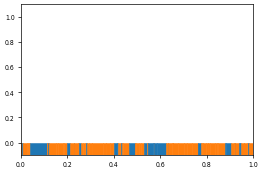

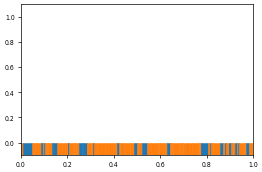

In [10]:
# Create the random rod object
R = RandomRod(100,         # The number of segments
              [0.3, 0.7],  # The concentration of each material
              [0.045, 38.0])  # The thermal conductivity of each material
# Let's sample a few of them and plot them
for n in range(5):
    fig, ax = plt.subplots(dpi=50)
    R.rvs().plot(ax=ax)

Now that we have the ability to generate random rods, let's right a solar for the steady state heat equation.
This will also be a class that takes a given rod and solves the problem.

In [ ]:
# Fipy is used to solve the boundary value problem using a finite volume scheme
# You may have to install it if you don't have it using:
# RUN THIS BLOCK IF YOU HAVEN'T INSTALLED fipy yet
!pip install fipy

In [11]:
import fipy

class SteadyStateHeat1DSolver(object):
    
    """
    Solves the 1D steady state heat equation with dirichlet boundary conditions.
    It uses the stochastic model we developed above to define the random conductivity.
    
    Arguments:
    nx          -    Number of grid points
    value_left  -    The value at the left side of the boundary.
    value_right -    The value at the right side of the boundary.
    """
    
    def __init__(self, nx=500, value_left=400.0, value_right=4.0):
        self.nx = nx
        self.dx = 1. / nx
        # A computational mesh with nx elements
        self.mesh = fipy.Grid1D(nx=self.nx, dx=self.dx)
        # A variable that represents that temperature on the mesh
        self.phi = fipy.CellVariable(name='$T(x)$', mesh=self.mesh, value=0.)
        # A variable that represents the thermal conductivity
        self.C = fipy.FaceVariable(name='$C(x)$', mesh=self.mesh, value=1.)
        # The constrain on the left boundary
        self.phi.constrain(value_left, self.mesh.facesLeft)
        # The constrain on the right boundary
        self.phi.constrain(value_right, self.mesh.facesRight)
        # The The diffusion term
        self.eq = fipy.DiffusionTerm(coeff=self.C)
        
    def __call__(self, rod):
        """
        Evaluates the code at a specific xi.
        """
        # Find the values of the mesh points
        x = self.mesh.faceCenters.value.flatten()
        # Evaluate the conductivity on these points using the rod model
        cond_val = rod.get_conductivity(x)
        # Update conductivity values in the equation
        self.C.setValue(cond_val)
        # Solve the equation
        self.eq.solve(var=self.phi)
        # Return the solution
        return x, self.phi.faceValue()

Let's draw some random rods and plot the temperature profile for each one of them

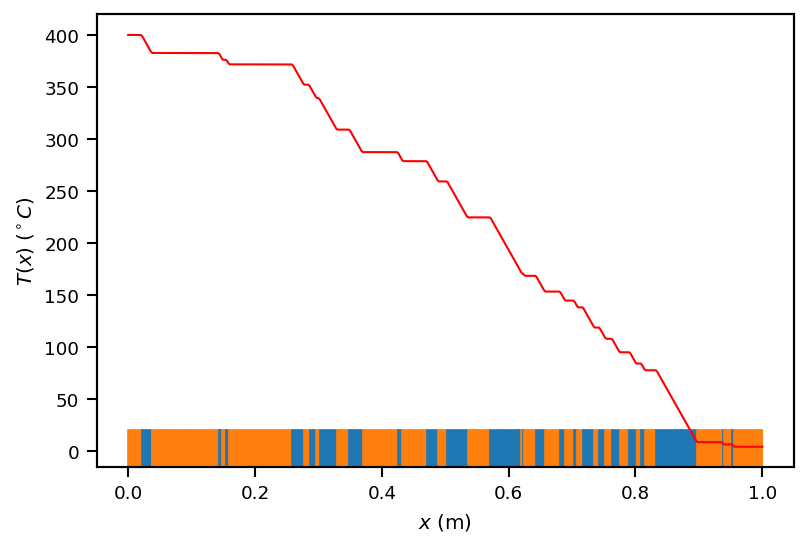

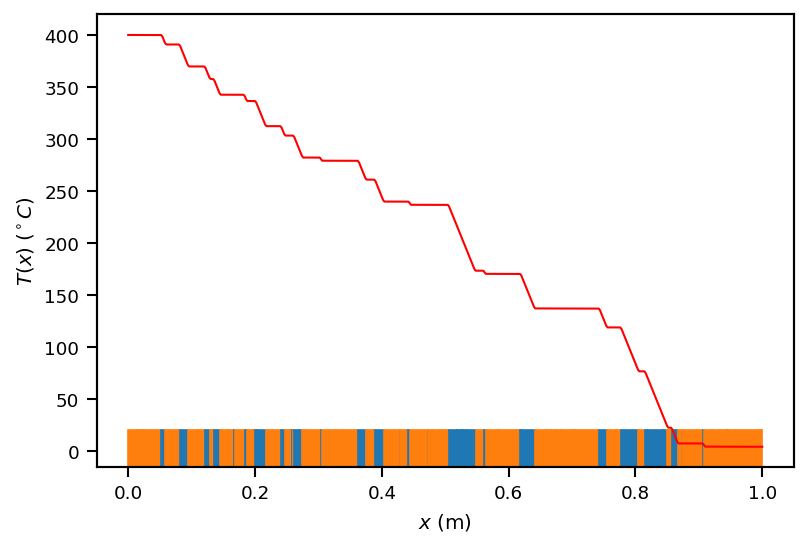

In [12]:
solver = SteadyStateHeat1DSolver(nx=500)
for i in range(2):
    fig, ax = plt.subplots(dpi=150)
    rod = R.rvs()
    x, y = solver(rod)
    # plot the rod
    rod.plot(ax=ax)
    # Get rid of the y ticks for the rod
    ax.set_yticks([])
    # Get another axis to plot the temperature
    ax1 = ax.twinx()
    # Make sure the ticks for this axis are on the left
    ax1.yaxis.tick_left()
    # Same for the label
    ax1.yaxis.set_label_position("left")
    # Plot the temperature
    ax1.plot(x, y, 'r', lw=1)
    ax.set_xlabel('$x$ (m)')
    ax1.set_ylabel(r'$T(x)\;(^\circ C)$');

Now let's draw multiple samples and plot them on the same figure:

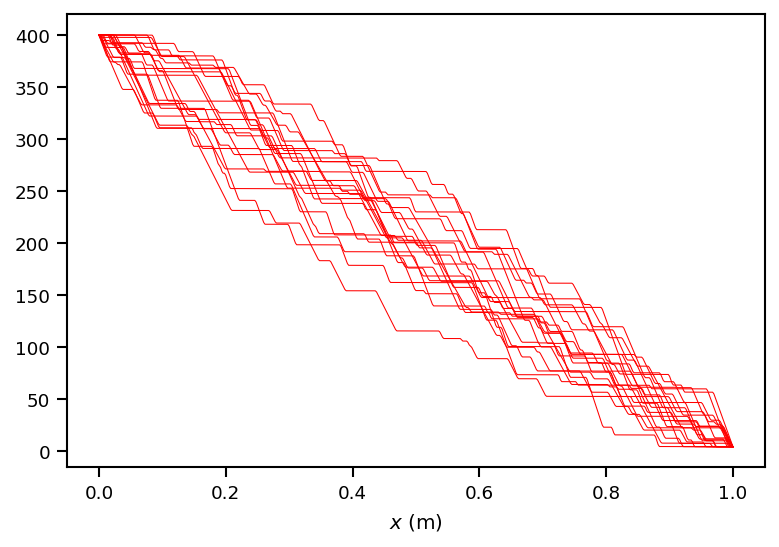

In [13]:
# Let's now just plot many samples of the temperature profile on the same plot
fig, ax = plt.subplots(dpi=150)
for i in range(20):
    rod = R.rvs()
    x, y = solver(rod)
    ax.plot(x, y, 'r', lw=0.5)
    ax.set_xlabel('$x$ (m)')
    ax1.set_ylabel(r'$T(x)\;(^\circ C)$');

Okay, it looks like our classes are working as expected. Now let's use them to do Monte Carlo.

### Uncertainty propagation through the boundary value problem

We start by generating the data so that we can reuse them later to analyze various quantities of interest.
It's also a good idea to write the data to a file that we can reuse later without rerunning the notebook. This is especially useful if we are using computationally expensive simulators.

In [14]:
# Number of samples to take
N = 1000

# A place to store the results of all simulations
data = np.ndarray((N, solver.nx + 1))

# Loop over samples
for n in range(N):
    # Draw a random rod
    rod = R.rvs()
    # Evaluate the solver at this rod
    y = solver(rod)[1]
    # Store the data for later use
    data[n, :] = y
    
# Okay, we have the data. Let's write them to a file in the simplest possible way
# (using a text format). IF YOU ARE ON GOOGLE COLAB THE FILE IS 
data_filename = 'steady_state_heat_N={0:d}.txt'.format(N)
# This saves the data:
np.savetxt(data_filename, data)

Here is how you can reload the data (this doesn't require running the code above if you have already done it).

In [15]:
# The file to read (MAKE SURE YOU CHANGE THIS IF YOU WNAT TO READ ANOTHER FILE)
# IF YOU ARE ON GOOGLE COLAB THE FILE 
input_filename = 'steady_state_heat_N=1000.txt'
# This is just a check that the file exists
import os
if not os.path.exists(input_filename):
    raise RuntimeError('File "{0:s}" does not exist.'.format(input_filename)
                       + 'Make sure you run code above with the appropriate parameters')
# If you reach this point, the file exists. Load it:
data = np.loadtxt(input_filename)
print('Loaded data shape: ', data.shape)
# Make sure N reflects the correct data set
N = data.shape[0]

Loaded data shape:  (1000, 501)


And now we can use the ``data`` to estimate statistics using Monte Carlo.
Let's start with the expectation of $T(x)$ at a single point, say $x=0.5$.
That is, we want to estimate $\mathbb{E}[T(x=0.5)]$ where the expectation is over the random rods.
Here is how we can do it:

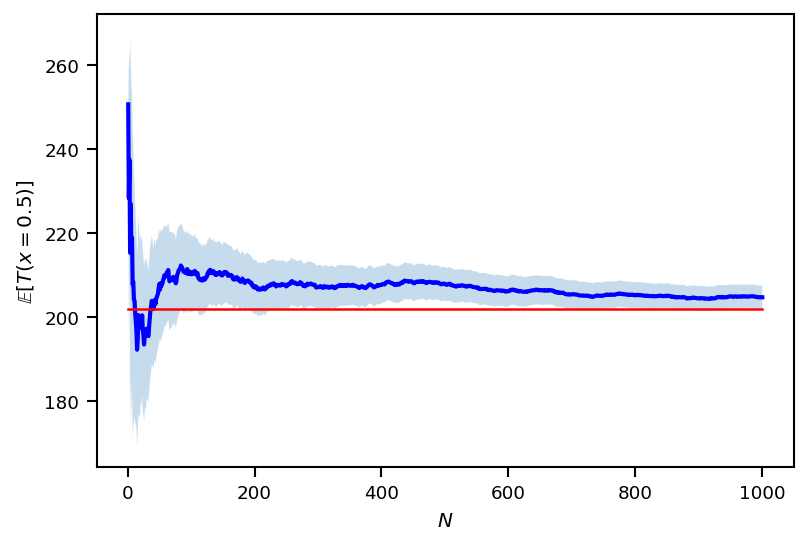

In [19]:
# Extract only the relevant data
T_middle_data = data[:, int(solver.nx / 2)]

# Evaluate the sample average 
T_middle_running = np.cumsum(T_middle_data) / np.arange(1, N + 1)

# Evaluate the sample average for the squared of T_middle
T_middle2_running = np.cumsum(T_middle_data ** 2) / np.arange(1, N + 1)

# Evaluate the running average of the variance
sigma2_running = T_middle2_running - T_middle_running ** 2

# Alright, now we have quantified our uncertainty about I for every N
# from a single MC run. Let's plot a (about) 95% predictive interval
# Running lower bound for the predictive interval
T_middle_lower_running = T_middle_running - 2.0 * np.sqrt(sigma2_running / np.arange(1, N + 1))
# Running upper bound for the predictive interval
T_middle_upper_running = T_middle_running + 2.0 * np.sqrt(sigma2_running / np.arange(1, N + 1))

# A common plot for all estimates
fig, ax = plt.subplots(dpi=150)
# Shaded area for the interval
ax.fill_between(np.arange(1, N + 1), T_middle_lower_running, T_middle_upper_running, alpha=0.25)
# Here is the MC estimate:
ax.plot(np.arange(1, N+1), T_middle_running, 'b', lw=2)
# The true value
ax.plot(np.arange(1, N+1), [(4.0 + 400.0) / 2] * N, color='r')
# and the labels
ax.set_xlabel('$N$')
ax.set_ylabel(r'$\mathbb{E}[T(x=0.5)]$');

### Questions
+ How many samples do you need to take for this to be sufficiently converged? Remember, you cannot really see the red line. Say that you want to make sure that you have second digit accuracy in the expected mean at the center with 95% probability.

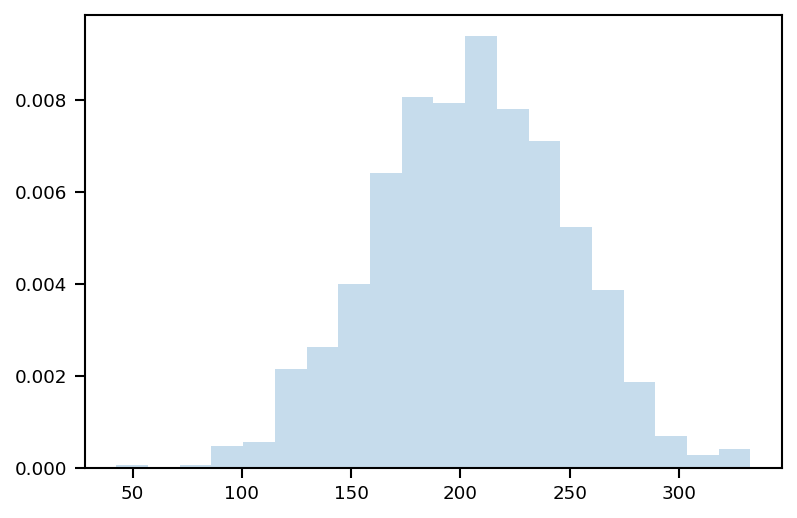

In [20]:
fig, ax = plt.subplots(dpi=150)
ax.hist(T_middle_data, density=True, alpha=0.25, bins=20);

Let's now find the median and a 95% predictive interval.

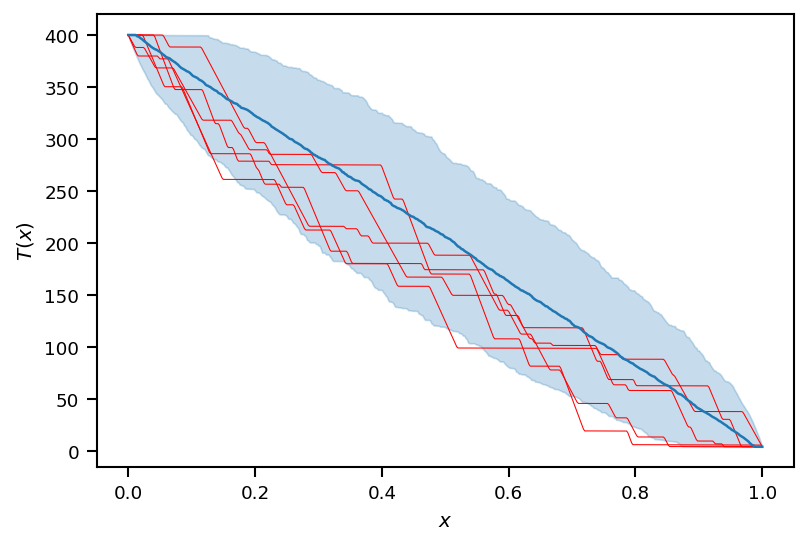

In [21]:
mu = np.median(data, axis=0)
mu_025 = np.percentile(data, 2.5, axis=0)
mu_975 = np.percentile(data, 97.5, axis=0)

fig, ax = plt.subplots(dpi=150)
ax.fill_between(x, mu_025, mu_975, color=sns.color_palette()[0], alpha=0.25)
# Let's take a couple of samples and see if they fall inside:
for _ in range(5):
    rod = R.rvs()
    y = solver(rod)[1]
    ax.plot(x, y, 'r', lw=0.5)
ax.plot(x, mu)
ax.set_xlabel('$x$')
ax.set_ylabel('$T(x)$');

### Questions

+ Modify the code above to plot a series of quantiles that will give you an idea of the underlying probability density on the space of $T(x)$'s. Plot the $5, 10, 15, 20, 25, 30, 35,\ldots, 80, 85, 90, 95\%$ quantiles.
+ Use the data you have collected in ``data`` to estimate the probability that $T(x=0.5)$ is greater than $0.6$.